In [1]:
# This script classifies gaze of participant into: looking at another participant, looking away, or in transition

# To do this, head pose (rotation euler angles and position) is required (calculated with c++ analysis component)

# The https://github.com/idiap/vfoa.git repository is used to calculate gaze state

In [2]:
import re
import matplotlib.pyplot as plt
from enum import Enum
import os

In [3]:
#define location of data to process

# data_dir="C:/Users/gary4/Documents/repos/Recording-And-Analysis-Plugin/Data/group0"
# data_dir="Z:/Gary/Research/APlausE-MR_MR4_CollaborativeTelepresenceStudy/gazeAnalysis/group0"
data_dir="C:/Users/gary4/Documents/Work/BUW/Research/MR4/transformFiles"

files = os.listdir(data_dir)
files_to_process = [f for f in files if "quantitative_requests_results.csv" in f] 

print("Found " + str(len(files_to_process)) + " files to process")


Found 1 files to process


In [4]:
# define some constants

cols = ['#EE204D', '#1CAC78', '#1F75FE', '#FCE883']

sample_rate = 10.0
sample_interval = 1 / sample_rate


In [5]:
class GazeState(Enum):
    TRANSITION = 0
    LOCAL = 1
    REMOTE_ADJACENT = 2
    REMOTE_OPPOSITE = 3
    AVERTED = 4
    
# Define colors for each GazeState
gaze_state_colors = {
    GazeState.TRANSITION: 'lightgray',
    GazeState.LOCAL: 'limegreen',
    GazeState.REMOTE_ADJACENT: 'yellow',
    GazeState.REMOTE_OPPOSITE: 'cornflowerblue',
    GazeState.AVERTED: 'black',
}

In [6]:
# define some data structures for reading data

class HeadPoseData:
    def __init__(self, desc):
        self.times = []
        self.rot_values = []
        self.pos_values = []
        
        # find participant ID for gazer
        participant_label_ends = [m.end() for m in re.finditer('Participant', desc)]
        self.gazer = int(desc[participant_label_ends[0]])
        
    def add_values(self,time,pos,rot):
        self.times.append(time)
        self.rot_values.append(rot)
        self.pos_values.append(pos)
    
    

In [7]:
class GazeClassification:

    def __init__(self, gazer):
        self.times = []
        self.values = []
        self.gazer = gazer
        
    def add_value(self,time,value):
        self.times.append(time)
        self.values.append(value)

def GetGazeStateFromGazerAndTarget(gazer, gaze_target):
    if gazer == gaze_target:
        raise RuntimeError("gazer and target cannot be the same")
    if (gazer + gaze_target) % 2 == 0:
        return GazeState.REMOTE_OPPOSITE
    if int(gazer / 2) == int(gaze_target / 2):
        return GazeState.LOCAL
    
    return GazeState.REMOTE_ADJACENT


# def ClassifyGaze(gazer, trial_length, rotation_streams, ang_distance_streams):
    
    
#     gazer_rot_streams = [r for r in rotation_streams if r.gazer == gazer] 
#     if len(gazer_rot_streams) > 1:
#         raise RuntimeError("Multiple rotation streams for gazer found")
    
#     gazer_ang_distance_streams = [a for a in ang_distance_streams if a.gazer == gazer]
#     if len(gazer_ang_distance_streams) != 3:
#         raise RuntimeError("Wrong number of angular distance streams for gazer found")
    
#     classification = GazeClassification(gazer)
    
#     t = 0.0
#     while t < trial_length:
        
#         # do classification
#         # check rotation is below threshold (otherwise this is a transition)
#         state = GazeState.TRANSITION
#         rot_at_t = get_value_at_time(gazer_rot_streams[0], t)
#         if rot_at_t < ROTATION_THRESHOLD:
            
#             # find best angle (if any below threshold)
#             state = GazeState.AVERTED
#             gaze_target = -1
#             best_angle = 180
            
#             for stream in gazer_ang_distance_streams:
#                 angle = get_value_at_time(stream, t)
#                 if angle < ANGLE_THRESHOLD and angle < best_angle:
#                     best_angle = angle
#                     gaze_target = stream.gaze_target
                
#             # determine state if gaze not averted
#             if gaze_target != -1:
#                 state = GetGazeStateFromGazerAndTarget(gazer, gaze_target)
        
#         classification.add_value(t,state)
#         t += sample_interval
    
#     return classification



In [29]:
from vfoa.vfoa_module import VFOAModule, Person, Target

modelName = "geometricalModel"
vfoaModule = VFOAModule(modelName)

# def get_vfoa(subject, targetList, frameIndex):
#     """ Return probabilities that <subject> looks at each target in <targetList> """
#     headpose = [subject.headpose.x, subject.headpose.y, subject.headpose.z, 
#                 subject.headpose.yaw, subject.headpose.pitch, subject.headpose.roll]
#     gaze = [subject.gaze.x, subject.gaze.y, subject.gaze.z, 
#                 subject.gaze.yaw, subject.gaze.pitch, subject.gaze.roll]
#     bodypose = [subject.bodypose.x, subject.bodypose.y, subject.bodypose.z, 
#                 subject.bodypose.yaw, subject.bodypose.pitch, subject.bodypose.roll]
#     speaking = subject.isSpeaking
#     personDict = {subject.name: Person(subject.name, headpose, gaze, bodypose, speaking)}
    
#     targetDict = {}
#     for target in targetList:
#         position = [target.position.x, target.position.y, target.position.z]
#         targetDict[target.name] = Target(target.name, position)
    
#     vfoaModule.compute_vfoa(personDict, targetDict, frameIndex)
#     return vfoaModule.get_vfoa_best(subject.name)


def ClassifyGazeWithVFOALib(gazer, trial_length, head_pose_streams):
    
    gazer_streams = [hps for hps in head_pose_streams if hps.gazer == gazer] 
    if len(gazer_rot_streams) != 1:
        raise RuntimeError("Wrong number of head pose streams for gazer found")

    target_streams = [hps for hps in head_pose_streams if hps.gazer != gazer] 
    if len(target_streams) != 3:
        raise RuntimeError("Wrong number of head pose streams for targets found")
    
    classification = GazeClassification(gazer)
    
    num_frames = max([len(hps.times) for hps in head_pose_streams])
    
    for f in range(num_frames):
                     
        headpose = gazer_streams[0].pos_values[f] + gazer_streams[0].rot_values[f] 
        gaze = None
        bodypose = None
        speaking = None
        
        targetDict = {}
        for target in target_streams:
            position = target.pos_values[f]
            targetDict[target.gazer] = Target(target.gazer, position)
                     

        vfoaModule.compute_vfoa(personDict, targetDict, frameIndex)
        results = vfoaModule.get_vfoa_best(subject.name)            

        state = GazeState.TRANSITION
        classification.add_value(gazer_streams[0].times[f], state)
                     #     while t < trial_length:
        
#         # do classification
#         # check rotation is below threshold (otherwise this is a transition)
#         state = GazeState.TRANSITION
#         rot_at_t = get_value_at_time(gazer_rot_streams[0], t)
#         if rot_at_t < ROTATION_THRESHOLD:
            
#             # find best angle (if any below threshold)
#             state = GazeState.AVERTED
#             gaze_target = -1
#             best_angle = 180
            
#             for stream in gazer_ang_distance_streams:
#                 angle = get_value_at_time(stream, t)
#                 if angle < ANGLE_THRESHOLD and angle < best_angle:
#                     best_angle = angle
#                     gaze_target = stream.gaze_target
                
#             # determine state if gaze not averted
#             if gaze_target != -1:
#                 state = GetGazeStateFromGazerAndTarget(gazer, gaze_target)
        
#         classification.add_value(t,state)
#         t += sample_interval
    
#     return classification



C:\Users\gary4\Documents\repos\Recording-And-Analysis-Plugin\Python\vfoa\methods\geometrical_model.py:58: SyntaxWarning: "is" with a literal. Did you mean "=="?
  self.vfoa = {'aversion': int(nearestTarget is 'aversion')}


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (geometry.py, line 69)

In [17]:
# Function to plot multiple HeadRotationResults on different line graphs

def plot_head_rotation_results(head_pose_stream):
    num_plots = 3
    
    
    # Create subplots
    fig, axes = plt.subplots(num_plots, 1, figsize=(20, num_plots * 3), sharex=True)
    
    data = []
    for i in range(3):
        data.append( [p[i] for p in head_pose_stream.rot_values] )
    
    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one subplot

    labels = ['x rot', 'y rot', 'z rot']
        
    # Plot each rotation euler angle on a different line graph
    for i, ax in enumerate(axes):
        ax.plot(head_pose_stream.times, data[i], label=labels[i], color=cols[i])
        ax.set_title(f'Head Rotation for Participant {head_pose_stream.gazer}')
        ax.set_ylabel('Rotation Value')
        ax.legend()
        ax.grid(True)
    
    # Set common x-label
    plt.xlabel('Time')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()


In [25]:
# Function to plot multiple HeadRotationResults on different line graphs

def plot_head_position_results(head_pose_stream):
    num_plots = 3
    # Create subplots
    fig, axes = plt.subplots(num_plots, 1, figsize=(20, num_plots * 3), sharex=True)
    
    data = []
    for i in range(3):
        data.append( [p[i] for p in head_pose_stream.pos_values] )
    
    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one subplot

    labels = ['x pos', 'y pos', 'z pos']
        
    # Plot each rotation euler angle on a different line graph
    for i, ax in enumerate(axes):
        ax.plot(head_pose_stream.times, data[i], label=labels[i], color=cols[i])
        ax.set_title(f'Head Position for Participant {head_pose_stream.gazer}')
        ax.set_ylabel('Position')
        ax.legend()
        ax.grid(True)
    
    # Set common x-label
    plt.xlabel('Time')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()


In [21]:


def PlotClassificationResultsForGazer(gazer, rotation_streams, ang_distance_streams, classifications):
    
    hrs = [r for r in rotation_streams if r.gazer == gazer] 
    head_rotation = hrs[0] 

    ads = [a for a in ang_distance_streams if a.gazer == gazer]
    angular_distance_1 = ads[0]
    angular_distance_2 = ads[1]
    angular_distance_3 = ads[2]

    gaze_classification = classifications[gazer]

    # Convert GazeClassification data to segments
    segments = []
    for i in range(len(gaze_classification.times) - 1):
        start_time = gaze_classification.times[i]
        duration = gaze_classification.times[i + 1] - start_time
        gaze_state = gaze_classification.values[i]
        segments.append((start_time, duration, gaze_state))


    # Create a figure and a set of subplots
    fig, axs = plt.subplots(3, 1, figsize=(20, 9), sharex=True)

    # Plot Head Rotation Results
    axs[0].plot(head_rotation.times, head_rotation.values, color='gray')
    axs[0].set_title(f'Head Rotation Results for Participant {head_rotation.gazer}')
    axs[0].set_ylabel('Rotation (Degrees)')

    for ad in range(3):
        # Plot Angular Distance Results
        axs[1].plot(ads[ad].times, ads[ad].values, label=f'P{ads[ad].gazer} to P{ads[ad].gaze_target}')
    axs[1].set_title("Gaze Angle from Participants")
    axs[1].set_ylabel('Angle (Degrees)')
    axs[1].legend()

    # Plot Gaze Classification as a horizontal bar
    for segment in segments:
        axs[2].broken_barh([(segment[0], segment[1])], (0, 1), facecolors=gaze_state_colors[GazeState(segment[2])])

    axs[2].set_title(f'Gaze Classification for Participant {gaze_classification.gazer}')
    axs[2].set_yticks([])
    axs[2].set_yticklabels([])
    axs[2].set_ylim(0, 1)
    axs[2].set_xlim(0, gaze_classification.times[-1])
    axs[2].set_ylabel('Gaze State')

    # Add a color legend for the gaze states
    legend_patches = [plt.Rectangle((0,0),1,1, color=gaze_state_colors[state]) for state in GazeState]
    axs[2].legend(legend_patches, [state.name for state in GazeState], loc='upper right')

    # Final adjustmentst
    plt.tight_layout()
    plt.show()



In [26]:

def LoadFile(file_name): 

    file_path = data_dir + "/" + file_name
    print("Processing file: " + file_path)

    # read data from file into structures
    head_pose_streams = []
    
    f = open(file_path, "r")

    while True:
        line = f.readline()
        if not line:
            break

        if line.startswith("AnalysisQuery"):
            head_pose_streams.append(HeadPoseData(line))
        elif line.startswith('Time') or not line.strip():
            pass
        else:
            in_data = line.split(',')
            in_data = [float(n) for n in in_data]
            head_pose_streams[-1].add_values(in_data[0], [in_data[1], in_data[2], in_data[3]], \
                                             [in_data[4], in_data[5], in_data[6]])

    f.close()

    # get length of trial
    trial_length = max([stream.times[-1] for stream in head_pose_streams])
    print("Trial length: " + str(trial_length))
    
    return head_pose_streams
    
  
    
    

In [22]:

def WriteResults(classification_results_all_ps, input_file_path):
    out_file_path = input_file_path.replace("quantitative_requests_results", "gaze_classification_results")
    
    with open(out_file_path, "w") as file:
        for r in classification_results_all_ps:
            file.write("AnalysisQuery,GazeClassification Participant" + str(r.gazer) + "\n")
            file.write("RotationThreshold," + str(ROTATION_THRESHOLD) + "\n")
            file.write("AngleThreshold," + str(ANGLE_THRESHOLD) + "\n")
            file.write("Time,State\n")
            for t, state in zip(r.times, r.values):
                file.write(str(t) + "," + str(state.value) + "\n")
              
    print("Wrote results to file " + out_file_path)


Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/transformFiles/aplausemr_group2_date20240709_13_56_trial0_experimentcontroller_quantitative_requests_results.csv
Trial length: 424.417


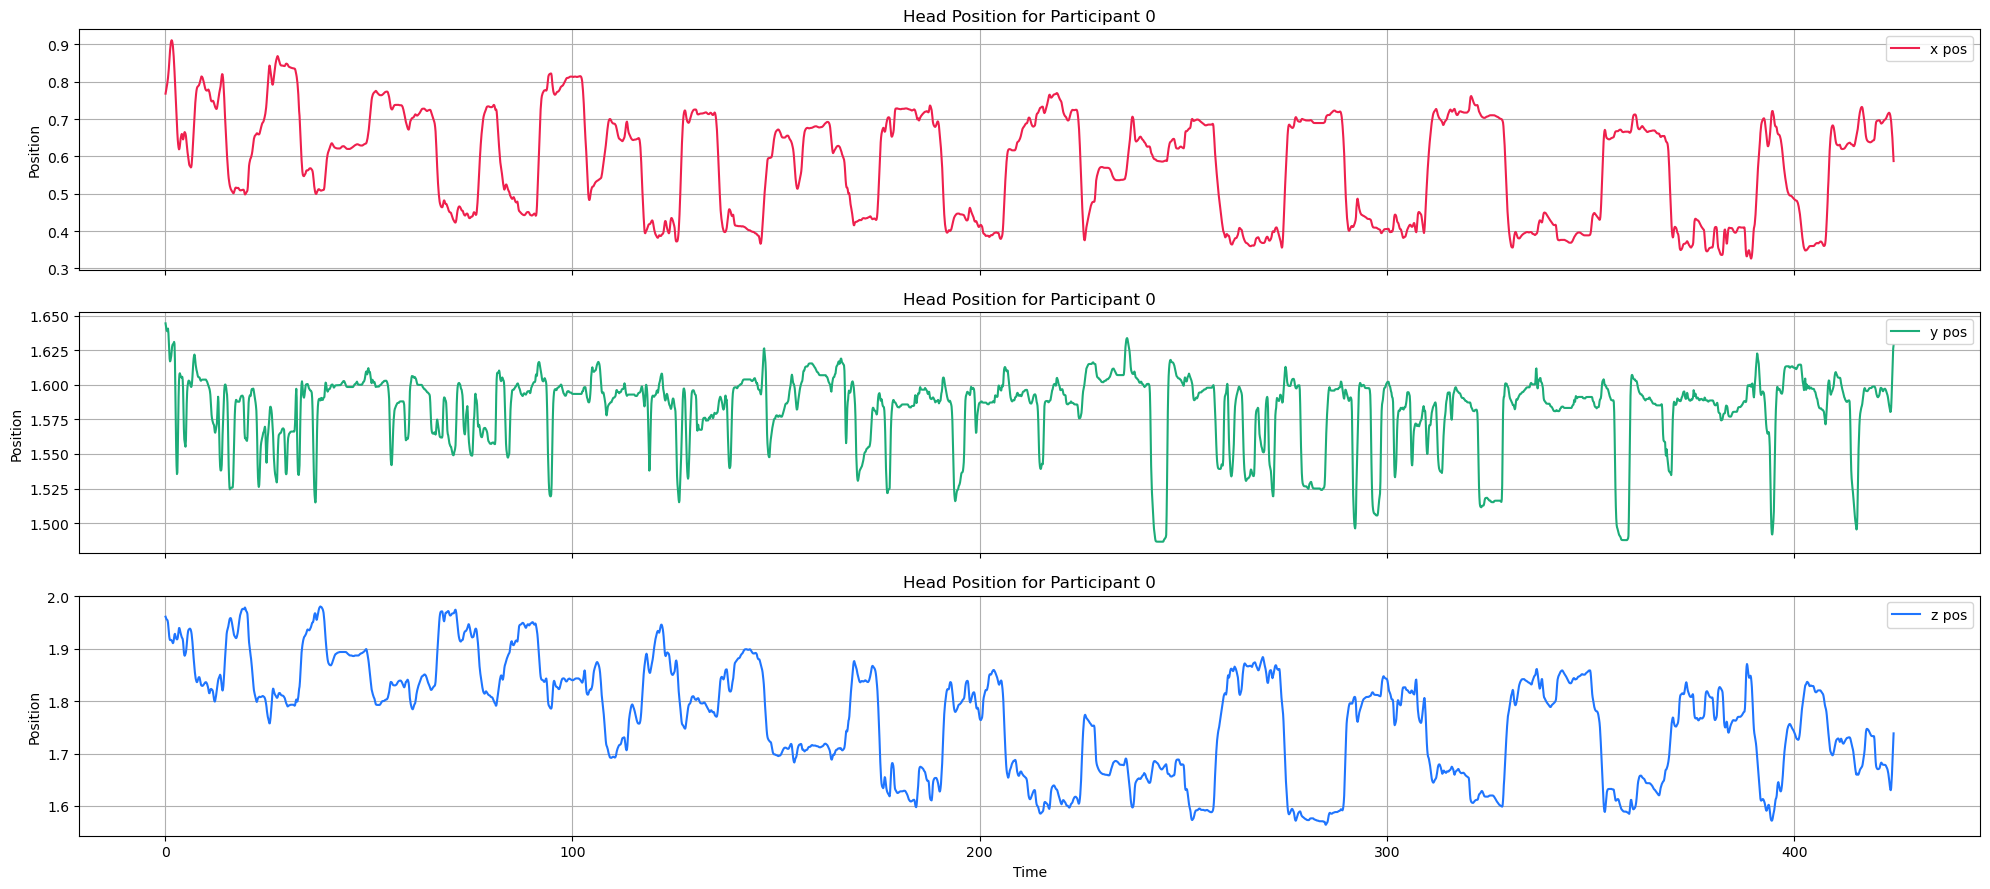

In [27]:
for f in files_to_process:
    head_pose_streams = LoadFile(f)
    
    plot_head_rotation_results(head_pose_streams[0])
    plot_head_position_results(head_pose_streams[0])
    
    
    classifications = []
    for p in range(NUM_PARTICIPANTS):
#         classifications.append(ClassifyGazeWithVFOALib(p, trial_length, rotation_streams, ang_distance_streams))
        

#     if "trial0" in file_name and "group0" in file_name:
#         PlotClassificationResultsForGazer(1, rotation_streams, ang_distance_streams, classifications)    

#     WriteResults(classifications, file_path)
    